# Code for Final Project for CSCI 6502-001B - Big Data Analytics - Text Summarization with T5
## Nate Omdalen

This notebook contains the training and testing of the T5 summarization network using the WikiHow and CNN datasets.

### Installs and Imports

In [ ]:
#If you are using Colab, you will need to install these

!pip install nlp
!pip install rouge_score
!pip install transformers
!pip install sentencepiece
!pip install ignite
!pip install pytorch-ignite
!pip install datasets

     |████████████████████████████████| 1.7 MB 7.7 MB/s 
     |████████████████████████████████| 212 kB 65.2 MB/s 
     |████████████████████████████████| 4.0 MB 9.8 MB/s 
     |████████████████████████████████| 77 kB 8.7 MB/s 
     |████████████████████████████████| 895 kB 51.1 MB/s 
     |████████████████████████████████| 596 kB 63.9 MB/s 
     |████████████████████████████████| 6.6 MB 46.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 8.5 MB/s 
     |████████████████████████████████| 251 kB 8.4 MB/s 
     |████████████████████████████████| 325 kB 7.7 MB/s 
     |████████████████████████████████| 1.1 MB 61.7 MB/s 
     |████████████████████████████████| 136 kB 73.6 MB/s 
     |████████████████████████████████| 127 kB 54.3 MB/s 
     |████████████████████████████████| 144 kB 49.1 MB/s 
     |████████████████████████████████| 271 kB

In [ ]:
# Importing libraries
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nlp import load_dataset
from nlp import load_metric

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

from rouge_score import rouge_scorer
from transformers import T5Tokenizer, T5ForConditionalGeneration
from ignite.metrics import Rouge
import datasets


### Dataset Classes

In [ ]:
#This is a pytorch dataset class that will be used to handle the WikiHow Dataset

class wikihow(Dataset):
    def __init__(self, tokenizer, type_path, num_samples, input_length, output_length:         
        self.dataset =  load_dataset('wikihow', 'all', data_dir='data/', split=type_path)
        if num_samples:
            self.dataset = self.dataset.select(list(range(0, num_samples)))
        self.input_length = input_length
        self.tokenizer = tokenizer
        self.output_length = output_length
        self.print_text = print_text
  
    def __len__(self):
        return self.dataset.shape[0]
    
    def clean_text(self, text):
        text = text.replace('Example of text:', '')
        text = text.replace('Example of Summary:', '')
        text = text.replace('\n','')
        text = text.replace('``', '')
        text = text.replace('"', '')
        
        return text
       
    def convert_to_features(self, example_batch):              
        input_ = self.clean_text(example_batch['text'])
        target_ = self.clean_text(example_batch['headline'])
        
        source = self.tokenizer.batch_encode_plus([input_],
                                                  max_length=self.input_length,
                                                  padding='max_length',
                                                  truncation=True,
                                                  return_tensors="pt")
        
        targets = self.tokenizer.batch_encode_plus([target_],
                                                   max_length=self.output_length,
                                                   padding='max_length',
                                                   truncation=True,
                                                   return_tensors="pt")
    
        return source, targets
  
    def __getitem__(self, index):
        source, targets = self.convert_to_features(self.dataset[index])
        
        source_ids = source["input_ids"].squeeze()
        target_ids = targets["input_ids"].squeeze()

        src_mask    = source["attention_mask"].squeeze()
        target_mask = targets["attention_mask"].squeeze()

        return {"source_ids": source_ids,
                "source_mask": src_mask,
                "target_ids": target_ids,
                "target_mask": target_mask}
        
  


In [ ]:
#This is a pytorch dataset class that will be used to handle the CNN dataset

class CNN(Dataset):
    def __init__(self, tokenizer, type_path, num_samples, input_length, output_length):         
        self.dataset =  datasets.load_dataset('cnn_dailymail', '2.0.0', split=type_path)
        if num_samples:
            self.dataset = self.dataset.select(list(range(0, num_samples)))
        self.input_length = input_length
        self.tokenizer = tokenizer
        self.output_length = output_length
        self.print_text = print_text
  
    def __len__(self):
        return self.dataset.shape[0]
    
    def clean_text(self, text):
        text = text.replace('Example of text:', '')
        text = text.replace('Example of Summary:', '')
        text = text.replace('\n','')
        text = text.replace('``', '')
        text = text.replace('"', '')
        
        return text
    
    
    def convert_to_features(self, example_batch):          
        input_ = self.clean_text(example_batch['article'])
        target_ = self.clean_text(example_batch['highlights'])
        
        source = self.tokenizer.batch_encode_plus([input_],
                                                  max_length=self.input_length,
                                                  padding='max_length',
                                                  truncation=True,
                                                  return_tensors="pt")
        
        targets = self.tokenizer.batch_encode_plus([target_],
                                                   max_length=self.output_length,
                                                   padding='max_length',
                                                   truncation=True,
                                                   return_tensors="pt")
    
        return source, targets
  
    def __getitem__(self, index):
        source, targets = self.convert_to_features(self.dataset[index])
        
        source_ids = source["input_ids"].squeeze()
        target_ids = targets["input_ids"].squeeze()

        src_mask    = source["attention_mask"].squeeze()
        target_mask = targets["attention_mask"].squeeze()

        return {"source_ids": source_ids,
                "source_mask": src_mask,
                "target_ids": target_ids,
                "target_mask": target_mask}
        
  


### T5 Summarizer Class

In [ ]:
#This class contains the essential methods needed to train/test a T5 network

class T5Summarizer():
    def __init__(self, **kwargs):
        super(T5Summarizer, self).__init__()
        #Dataset = 'wikihow' or 'CNN'
        self.dataset = kwargs['Dataset']
        #Number of examples per batch
        self.batch_size = kwargs['Batch Size']
        #Device = either 'cuda' or 'cpu'
        self.device = kwargs['Device']
        #Learning rate for optimizer
        self.lr = kwargs['Learning Rate']
        #Model type, e.g., t5-small, t5-base
        self.model_type = kwargs['Model Type']
        #Number of epochs to train
        self.epochs = kwargs['Epochs']
        #Variable for storing pytorch model
        self.model = None
        #Optimizer to use, e.g. Adam
        self.optimizer = kwargs['Optimizer']
        #Number of samples
        self.num_samples = kwargs['Number of Samples']
        #Max input length of text
        self.input_length = kwargs['Input Length']
        #Max output length of text
        self.output_length = kwargs['Output Length']
        #Tech = 'All Parameters', 'Gradual', or 'Adapter'
        self.transfer_tech = kwargs['Transfer Technique']
        #Variable for holding huggingface tokenizer
        self.tokenizer = None
        #Function for computing rouge1 scores
        self.rouge_score = rouge_scorer.RougeScorer(['rouge1'],
                                                    use_stemmer=False)
        #Dictionary for storing results
        self.history = {'Train Loss': [],
                        'Train ROUGE': [],
                        'Test ROUGE': None}

    def init_dataloaders(self):
        """
        Initializes dataloaders based on dataset
        returns: train_loader and val_loader
        """

        #Initialize datasets
        if self.dataset == 'wikihow':
            train_dataset = wikihow(self.tokenizer,
                                    'train',
                                    None,
                                    self.input_length,
                                    self.output_length)
            
            val_dataset = wikihow(self.tokenizer,
                                  'validation',
                                  None,
                                  self.input_length,
                                  self.output_length)

        if self.dataset == 'CNN':
            train_dataset = CNN(self.tokenizer,
                                'train',
                                None,
                                self.input_length,
                                self.output_length)
            
            val_dataset = CNN(self.tokenizer,
                              'validation',
                              None,
                              self.input_length,
                              self.output_length)

        #Initialize Dataloaders
        train_loader = DataLoader(train_dataset,
                                  batch_size=self.batch_size,
                                  shuffle=True,
                                  num_workers=2)
        
        val_loader = DataLoader(val_dataset,
                                batch_size=self.batch_size,
                                shuffle=False,
                                num_workers=2)
        
        return train_loader, val_loader

    def init_model(self):
        """
        Initialize T5 summarization model from huggingface
        """
        #Load model
        self.model = T5ForConditionalGeneration.from_pretrained(self.model_type)
        #Send to device
        self.model = self.model.to(self.device)
        #Initialize tokenizer
        self.tokenizer = T5Tokenizer.from_pretrained(self.model_type)

    def get_text(self, data):
        """
        Given a batch of data from dataloader, returns
        target text and predicted text
        """

        #Get data
        y = data['target_ids'].to(self.device, dtype=torch.long)
        ids = data['source_ids'].to(self.device, dtype=torch.long)
        mask = data['source_mask'].to(self.device, dtype=torch.long)

        #Generate predicted id's
        generated_ids = self.model.generate(input_ids = ids,
                                            attention_mask = mask, 
                                            max_length=150, 
                                            num_beams=2,
                                            repetition_penalty=2.5, 
                                            length_penalty=1.0, 
                                            early_stopping=True)
        
        #Decode id's with tokenizer
        preds = [self.tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
        target = [self.tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]

        return target, preds

    def train(self):
        """
        Train T5
        """

        #Counter for tracking iterations
        iterations = 1

        #Counter for tracking attention blocks unfrozen - updated in gradual unfreezing only
        block = 1

        #Get dataloaders
        train_loader, val_loader = self.init_dataloaders()

        if self.transfer_tech == 'Adapter':
            #Get only the adapter parameters for optimizer
            params = [param for i in range(6) for param in self.model.encoder.block[i].layer[1].parameters()] + \
            [param for i in range(6) for param in self.model.decoder.block[i].layer[2].parameters()] 
            optimizer = self.optimizer(params, self.lr)

        if self.transfer_tech == 'Gradual':
            #Get only the last layer of encoder and decoder for starting training
            params = [param for param in self.model.decoder.block[5].parameters()] + \
            [param for param in self.model.encoder.block[5].parameters()]
            optimizer = self.optimizer(params, self.lr)

        if self.transfer_tech == 'All Parameters':
            #Optimize all model parameters
            optimizer = self.optimizer(self.model.parameters(), self.lr)

        for epoch in range(self.epochs):
            #Train Step
            self.model.train()
            for data in train_loader:
                #Get ids, masks, labels, etc.
                y = data['target_ids'].to(self.device, dtype = torch.long)
                y_ids = y[:, :-1].contiguous()
                lm_labels = y[:, 1:].clone().detach()
                lm_labels[y[:, 1:] == self.tokenizer.pad_token_id] = -100
                ids = data['source_ids'].to(self.device, dtype=torch.long)
                mask = data['source_mask'].to(self.device, dtype=torch.long)
                dec_mask = data['target_mask'].to(self.device, dtype=torch.long)

                #Push through model
                outputs = self.model(input_ids=ids, 
                                     attention_mask=mask, 
                                     decoder_attention_mask=None, 
                                     decoder_input_ids=y_ids, 
                                     labels=lm_labels)
                #Get loss of output
                loss = outputs[0]
                #Save train loss for iteration
                self.history['Train Loss'].append(loss.item())

                #If iteration >= 50, get moving average of train loss for print out
                if iterations >= 50:
                    update = sum(self.history['Train Loss'][-50:])/50
                else:
                    update = 0

                #Print out loss
                sys.stdout.write('\rEpoch %01d/%01d [Iteration %06d] -- Loss: %.4f -- ' % (epoch + 1, self.epochs, iterations, update))

                #Every 50 iterations, compute train rouge score
                if iterations % 50 == 0:
                    #Get target and predicted summaries
                    target, preds = self.get_text(data)
                    #Total rouge score for batch
                    total = 0
                    for i in range(len(target)):
                        #Compute rouge score
                        score = self.rouge_score.score(preds[i], target[i])
                        #add to total
                        total += score['rouge1'][2]
                        #Save score
                        self.history['Train ROUGE'].append(score)
                    #Print average result for batch
                    sys.stdout.write('ROUGE-1: %.4f' % (total/len(target)))
                    sys.stdout.write('\n')

                #If using gradual unfreezing, unfreeze block every 6553 iterations
                if self.transfer_tech == 'Gradual':
                    if iterations % 6553 == 0:
                        #Get next block of parameters
                        add_params = [param for param in self.model.decoder.block[5-block].parameters()] + \
                        [param for param in self.model.encoder.block[5-block].parameters()]
                        #Add to optimizer
                        optimizer.add_param_group({'params': add_params})
                        #Update block counter
                        block += 1

                #Backpropogation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                #Update iteration counter
                iterations += 1

    def test(self):
        """
        Test T5 model using designated dataset
        """

        #Get appropriate dataset
        if self.dataset == 'wikihow':
            test_dataset = wikihow(self.tokenizer,
                                   'test',
                                   None,
                                   self.input_length,
                                   self.output_length)

        if self.dataset == 'CNN':
            test_dataset = CNN(self.tokenizer,
                              'test',
                              None,
                              self.input_length,
                              self.output_length)

        #Init dataloader
        test_dataloader = DataLoader(test_dataset,
                                     batch_size=self.batch_size,
                                     shuffle=False,
                                     num_workers=2)

        #List for test Rouge scores
        scores = []

        #Counter for noting how many batches completed
        batches_done = 0

        self.model.eval()

        with torch.no_grad():

            for data in test_dataloader:
                #Get ids, masks, labels, etc.
                y = data['target_ids'].to(self.device, dtype = torch.long)
                y_ids = y[:, :-1].contiguous()
                lm_labels = y[:, 1:].clone().detach()
                lm_labels[y[:, 1:] == self.tokenizer.pad_token_id] = -100
                ids = data['source_ids'].to(self.device, dtype=torch.long)
                mask = data['source_mask'].to(self.device, dtype=torch.long)
                dec_mask = data['target_mask'].to(self.device, dtype=torch.long)

                #Push through model
                outputs = self.model(input_ids=ids, 
                                     attention_mask=mask, 
                                     decoder_attention_mask=None, 
                                     decoder_input_ids=y_ids, 
                                     labels=lm_labels)
                #Get target and predicted summaries
                target, preds = self.get_text(data)

                for i in range(len(target)):
                    #Get rouge score of prediction
                    score = self.rouge_score.score(preds[i], target[i])
                    #save score
                    scores.append(score['rouge1'][2])

                #update batches done
                batches_done += 1
                sys.stdout.write('\rBatches Done: %04d' % (batches_done))

        #Get average of test dataset results
        result = sum(scores)/len(scores)

        #Save average
        self.history['Test ROUGE'] = result

    def save_results(self, filename):
        """
        Given filename, saves history dict
        in pickle
        """
        with open(filename, 'wb') as handle:
            pickle.dump(self.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def save_model(self, filename):
        """
        Given filename, saves model state dict
        """
        torch.save(self.model.state_dict(), filename)



### Training

In this section, I train and test 3 T5 models, an 'All Paramters' model, a 'Gradual' model, and an 'Adapter' model

#### Fine-Tuning: All Paramters Method

In [ ]:
#Define parameters for all paramters model

params = {'Dataset': 'wikihow', 
          'Batch Size': 8,
          'Device': 'cuda',
          'Learning Rate': 3e-4,
          'Model Type': 't5-small',
          'Epochs': 2,
          'Optimizer': torch.optim.Adam,
          'Number of Samples': None,
          'Input Length': 512,
          'Output Length': 150,
          'Transfer Technique': 'All Parameters'}

In [ ]:
#Initialize

summarizer = T5Summarizer(**params)

In [ ]:
#Initialize

summarizer.init_model()

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

In [ ]:
#Train

summarizer.train()

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset wikihow downloaded and prepared to /root/.cache/huggingface/datasets/wikihow/all/1.2.0/cfb412ca2191fac028cae9a5a9a03ba21b08ff2b4bf46f8a0473d7303a3e3683. Subsequent calls will reuse this data.
Epoch 1/2 [Iteration 000050] -- Loss: 3.6292 -- ROUGE-1: 0.2253
Epoch 1/2 [Iteration 000100] -- Loss: 3.3419 -- ROUGE-1: 0.2866
Epoch 1/2 [Iteration 000150] -- Loss: 3.2362 -- ROUGE-1: 0.2078
Epoch 1/2 [Iteration 000200] -- Loss: 3.1512 -- ROUGE-1: 0.2211
Epoch 1/2 [Iteration 000250] -- Loss: 3.1750 -- ROUGE-1: 0.2195
Epoch 1/2 [Iteration 000300] -- Loss: 3.0746 -- ROUGE-1: 0.2130
Epoch 1/2 [Iteration 000350] -- Loss: 3.1278 -- ROUGE-1: 0.2249
Epoch 1/2 [Iteration 000400] -- Loss: 3.0737 -- ROUGE-1: 0.2190
Epoch 1/2 [Iteration 000450] -- Loss: 3.0465 -- ROUGE-1: 0.3029
Epoch 1/2 [Iteration 000500] -- Loss: 2.9964 -- ROUGE-1: 0.1839
Epoch 1/2 [Iteration 000550] -- Loss: 2.9475 -- ROUGE-1: 0.2495
Epoch 1/2 [Iteration 000600] -- Loss: 2.9915 -- ROUGE-1: 0.2323
Epoch 1/2 [Iteration 000650] -- 

In [ ]:
#Test

summarizer.test()

Batches Done: 0698

In [ ]:
#Save results

summarizer.save_results('results_all_params.pkl')

In [ ]:
#Save model

summarizer.save_model('model_all_params.pt')

#### Fine-Tuning: Adapter Method

In [ ]:
#Define parameters for adapter method

params = {'Dataset': 'wikihow',
          'Batch Size': 8,
          'Device': 'cuda',
          'Learning Rate': 3e-4,
          'Model Type': 't5-small',
          'Epochs': 2,
          'Optimizer': torch.optim.Adam,
          'Number of Samples': None,
          'Input Length': 512,
          'Output Length': 150,
          'Transfer Technique': 'Adapter'}

In [ ]:
#Initialize

summarizer = T5Summarizer(**params)

In [ ]:
summarizer.init_model()

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

In [ ]:
#Train

summarizer.train()

Downloading:   0%|          | 0.00/7.98k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/75.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/75.2k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset wikihow downloaded and prepared to /root/.cache/huggingface/datasets/wikihow/all/1.2.0/cfb412ca2191fac028cae9a5a9a03ba21b08ff2b4bf46f8a0473d7303a3e3683. Subsequent calls will reuse this data.
Epoch 1/2 [Iteration 000050] -- Loss: 4.0007 -- ROUGE-1: 0.3214
Epoch 1/2 [Iteration 000100] -- Loss: 3.4898 -- ROUGE-1: 0.3001
Epoch 1/2 [Iteration 000150] -- Loss: 3.3495 -- ROUGE-1: 0.2571
Epoch 1/2 [Iteration 000200] -- Loss: 3.2840 -- ROUGE-1: 0.3007
Epoch 1/2 [Iteration 000250] -- Loss: 3.3500 -- ROUGE-1: 0.1982
Epoch 1/2 [Iteration 000300] -- Loss: 3.1922 -- ROUGE-1: 0.2279
Epoch 1/2 [Iteration 000350] -- Loss: 3.1900 -- ROUGE-1: 0.2194
Epoch 1/2 [Iteration 000400] -- Loss: 3.1871 -- ROUGE-1: 0.2751
Epoch 1/2 [Iteration 000450] -- Loss: 3.2205 -- ROUGE-1: 0.2297
Epoch 1/2 [Iteration 000500] -- Loss: 3.0803 -- ROUGE-1: 0.2445
Epoch 1/2 [Iteration 000550] -- Loss: 3.1534 -- ROUGE-1: 0.1734
Epoch 1/2 [Iteration 000600] -- Loss: 3.1073 -- ROUGE-1: 0.2604
Epoch 1/2 [Iteration 000650] -- 

In [ ]:
#Test

summarizer.test()

Batches Done: 0698

In [ ]:
#Save model

summarizer.save_model('model_adapter.pt')

In [ ]:
#Save results

summarizer.save_results('results_adapter.pkl')

#### Fine-Tuning: Gradual Unfreezing

In [ ]:
#Define parameters for gradual unfreezing model

params = {'Dataset': 'wikihow', 
          'Batch Size': 8,
          'Device': 'cuda',
          'Learning Rate': 3e-4,
          'Model Type': 't5-small',
          'Epochs': 2,
          'Optimizer': torch.optim.Adam,
          'Number of Samples': None,
          'Input Length': 512,
          'Output Length': 150,
          'Transfer Technique': 'Gradual'}

In [ ]:
#Initialize

summarizer = T5Summarizer(**params)

In [ ]:
summarizer.init_model()

In [ ]:
#Train

summarizer.train()

Epoch 1/2 [Iteration 000050] -- Loss: 4.0041 -- ROUGE-1: 0.3007
Epoch 1/2 [Iteration 000100] -- Loss: 3.4885 -- ROUGE-1: 0.2120
Epoch 1/2 [Iteration 000150] -- Loss: 3.3323 -- ROUGE-1: 0.2541
Epoch 1/2 [Iteration 000200] -- Loss: 3.3492 -- ROUGE-1: 0.2450
Epoch 1/2 [Iteration 000250] -- Loss: 3.2833 -- ROUGE-1: 0.2356
Epoch 1/2 [Iteration 000300] -- Loss: 3.2568 -- ROUGE-1: 0.2682
Epoch 1/2 [Iteration 000350] -- Loss: 3.1510 -- ROUGE-1: 0.2179
Epoch 1/2 [Iteration 000400] -- Loss: 3.2607 -- ROUGE-1: 0.2539
Epoch 1/2 [Iteration 000450] -- Loss: 3.1391 -- ROUGE-1: 0.2495
Epoch 1/2 [Iteration 000500] -- Loss: 3.1793 -- ROUGE-1: 0.2519
Epoch 1/2 [Iteration 000550] -- Loss: 3.1151 -- ROUGE-1: 0.2129
Epoch 1/2 [Iteration 000600] -- Loss: 3.0912 -- ROUGE-1: 0.1740
Epoch 1/2 [Iteration 000650] -- Loss: 3.1071 -- ROUGE-1: 0.2147
Epoch 1/2 [Iteration 000700] -- Loss: 3.0855 -- ROUGE-1: 0.2227
Epoch 1/2 [Iteration 000750] -- Loss: 3.0416 -- ROUGE-1: 0.2206
Epoch 1/2 [Iteration 000800] -- Loss: 3.

In [ ]:
#Test

summarizer.test()

Batches Done: 0698

In [ ]:
#Save Model

summarizer.save_model('model_gradual.pt')

In [ ]:
#Save results

summarizer.save_results('results_gradual.pkl')

### Visualize Training Behavior

In [ ]:
#Load results dictionaries for visualization/analysis

pickle_off = open("results_adapter.pkl","rb")
adapter_results = pickle.load(pickle_off)
pickle_off = open("results_gradual.pkl","rb")
gradual_results = pickle.load(pickle_off)
pickle_off = open("results_all_params.pkl","rb")
all_params_results = pickle.load(pickle_off)

In [ ]:
def moving_average(data, window_size):
    """
    Given list of data and window size,
    returns list of moving averages
    """

    moving_averages = []
      
    i = 0

    while i < len(data) - window_size + 1:       
        window = data[i : i + window_size]     
        window_average = round(sum(window) / window_size, 2)       
        moving_averages.append(window_average)
        i += 1

    return moving_averages

In [ ]:
#Defining window size

window= 300

In [ ]:
#Getting moving averages of rouge-1 precision score

adapter_results_r1_p = moving_average([i['rouge1'][0] for i in adapter_results['Train ROUGE']], window)
gradual_results_r1_p = moving_average([i['rouge1'][0] for i in gradual_results['Train ROUGE']], window)
all_params_results_r1_p = moving_average([i['rouge1'][0] for i in all_params_results['Train ROUGE']], window)

In [ ]:
#Getting moving averages of rouge-1 recall score

adapter_results_r1_r = moving_average([i['rouge1'][1] for i in adapter_results['Train ROUGE']], window)
gradual_results_r1_r = moving_average([i['rouge1'][1] for i in gradual_results['Train ROUGE']], window)
all_params_results_r1_r = moving_average([i['rouge1'][1] for i in all_params_results['Train ROUGE']], window)

In [ ]:
#Getting moving averages of rouge-1 f1 score

adapter_results_r1_f = moving_average([i['rouge1'][2] for i in adapter_results['Train ROUGE']], window)
gradual_results_r1_f = moving_average([i['rouge1'][2] for i in gradual_results['Train ROUGE']], window)
all_params_results_r1_f = moving_average([i['rouge1'][2] for i in all_params_results['Train ROUGE']], window)

In [ ]:
#Getting moving averages of train loss

adapter_train_loss = moving_average(adapter_results['Train Loss'], window)
gradual_train_loss = moving_average(gradual_results['Train Loss'], window)
all_params_train_loss = moving_average(all_params_results['Train Loss'], window)

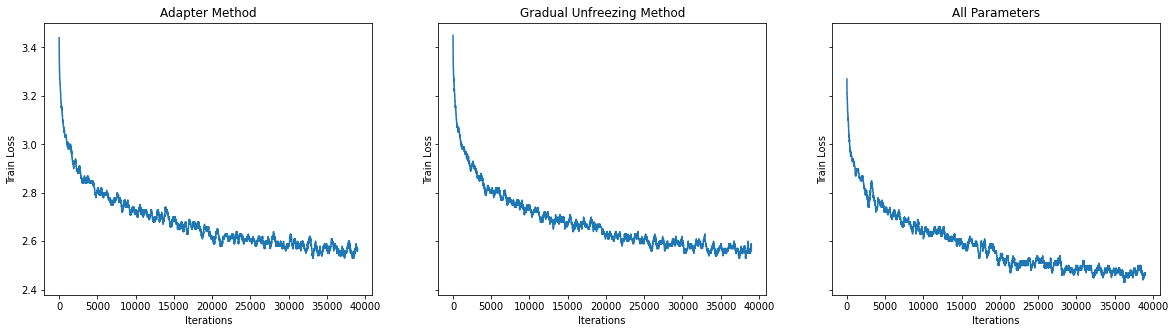

In [ ]:
#Plotting train loss

fig, axs = plt.subplots(1, 3, figsize=(20,5), sharey=True)

axs[0].plot(range(len(adapter_train_loss)), adapter_train_loss)
axs[0].set_title('Adapter Method')
axs[1].plot(range(len(gradual_train_loss)), gradual_train_loss)
axs[1].set_title('Gradual Unfreezing Method')
axs[2].plot(range(len(all_params_train_loss)), all_params_train_loss)
axs[2].set_title('All Parameters')

for ax in axs.flat:
    ax.set(xlabel='Iterations')
    ax.set(ylabel='Train Loss')

plt.show()

In [ ]:
#Computing length of moving average lists for plotting

length = len(adapter_results_r1_p)

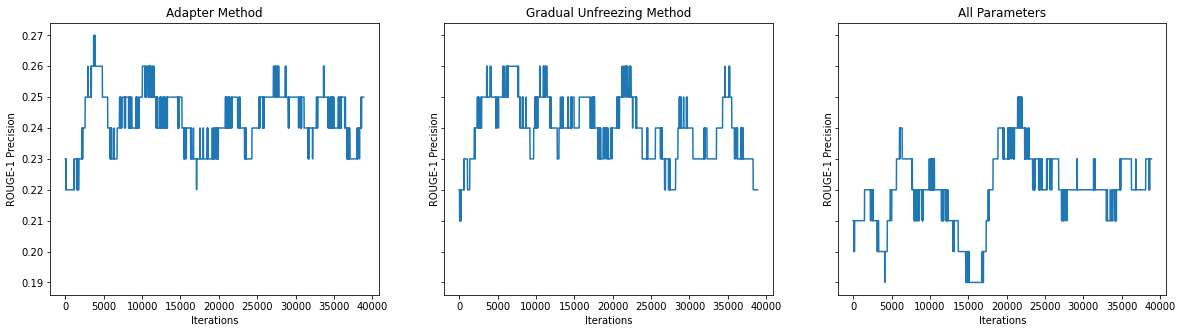

In [ ]:
#Plotting rouge-1 precision

fig, axs = plt.subplots(1, 3, figsize=(20,5), sharey=True)

axs[0].plot(range(length), adapter_results_r1_p)
axs[0].set_title('Adapter Method')
axs[1].plot(range(length), gradual_results_r1_p)
axs[1].set_title('Gradual Unfreezing Method')
axs[2].plot(range(length), none_results_r1_p)
axs[2].set_title('All Parameters')

for ax in axs.flat:
    ax.set(xlabel='Iterations')
    ax.set(ylabel='ROUGE-1 Precision')
    ax.set_xticks([770*i for i in range(9)])
    ax.set_xticklabels([i*5000 for i in range(9)])

plt.show()

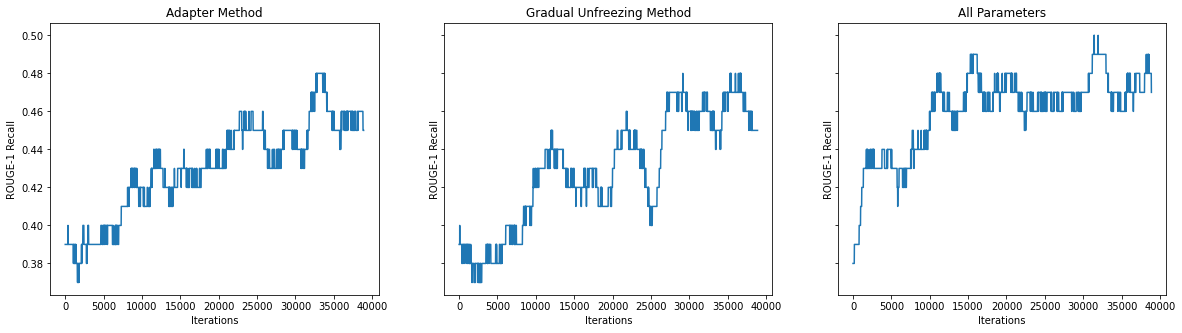

In [ ]:
#plotting rouge-1 recall

fig, axs = plt.subplots(1, 3, figsize=(20,5), sharey=True)

axs[0].plot(range(length), adapter_results_r1_r)
axs[0].set_title('Adapter Method')
axs[1].plot(range(length), gradual_results_r1_r)
axs[1].set_title('Gradual Unfreezing Method')
axs[2].plot(range(length), none_results_r1_r)
axs[2].set_title('All Parameters')

for ax in axs.flat:
    ax.set(xlabel='Iterations')
    ax.set(ylabel='ROUGE-1 Recall')
    ax.set_xticks([770*i for i in range(9)])
    ax.set_xticklabels([i*5000 for i in range(9)])

plt.show()

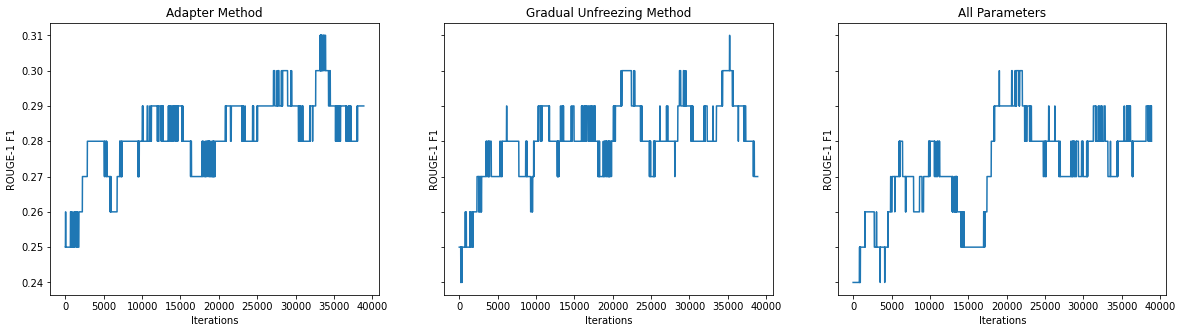

In [ ]:
#plotting rouge-1 f1

fig, axs = plt.subplots(1, 3, figsize=(20,5), sharey=True)

axs[0].plot(range(length), adapter_results_r1_f)
axs[0].set_title('Adapter Method')
axs[1].plot(range(length), gradual_results_r1_f)
axs[1].set_title('Gradual Unfreezing Method')
axs[2].plot(range(length), none_results_r1_f)
axs[2].set_title('All Parameters')

for ax in axs.flat:
    ax.set(xlabel='Iterations')
    ax.set(ylabel='ROUGE-1 F1')
    ax.set_xticks([770*i for i in range(9)])
    ax.set_xticklabels([i*5000 for i in range(9)])

plt.show()

### Testing on WikiHow Dataset

Before looking at the test results for the gradual, adapter, and all parameters model, we need to test a model that was not fine-tuned to use as a baseline.

In [ ]:
#Defining parameters to use for baseline model

params = {'Batch Size': 8,
          'Device': 'cuda',
          'Learning Rate': 3e-4,
          'Model Type': 't5-small',
          'Epochs': 2,
          'Optimizer': torch.optim.Adam,
          'Number of Samples': None,
          'Input Length': 512,
          'Output Length': 150,
          'Transfer Technique': None}

In [ ]:
#Initializing

summarizer = T5Summarizer(**params)

In [ ]:
summarizer.init_model()

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

In [ ]:
#Testing baseline

summarizer.test()

Downloading:   0%|          | 0.00/7.98k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/75.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/75.2k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset wikihow downloaded and prepared to /root/.cache/huggingface/datasets/wikihow/all/1.2.0/cfb412ca2191fac028cae9a5a9a03ba21b08ff2b4bf46f8a0473d7303a3e3683. Subsequent calls will reuse this data.
Batches Done: 0698

In [ ]:
#Baseline Test Results

summarizer.history['Test ROUGE']

0.23587597571502295

In [ ]:
#Adapter Test Results

adapter_results['Test ROUGE']

0.2905187252982662

In [ ]:
#Gradual Unfreezing Test Results

gradual_results['Test ROUGE']

0.3025343606662707

In [ ]:
#All Parameters Test Results

all_params_results['Test ROUGE']

0.27575248521805257

### Looking At Examples From WikiHow

In this section, I take a look at some example summaries generated by each model using the test WikiHow dataset

In [ ]:
#List of model names - to be used to grab files

model_names = ['adapter', 'gradual', 'all_params', 'baseline']

In [ ]:
#Generic params - used only to load model weights fine-tuned above

params = {'Batch Size': 8,
          'Device': 'cuda',
          'Learning Rate': 3e-4,
          'Model Type': 't5-small',
          'Epochs': 2,
          'Optimizer': torch.optim.Adam,
          'Number of Samples': None,
          'Input Length': 512,
          'Output Length': 150,
          'Transfer Technique': None}

In [ ]:
#Initializing tokenizer, test dataset and dataloader - for getting some examples

tokenizer = T5Tokenizer.from_pretrained('t5-small')
test_dataset = wikihow(tokenizer, 'test', None, 512, 150)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=2)

In [ ]:
#This examples dictionary will hold the generated summaries for each model
examples = {}
#This list will hold the original articles
orig_articles = []

In [ ]:
#Generating predicted summaries - grabbing first batch from dataloader to get examples

for data in test_dataloader:
    #iterate through models
    for name in model_names:
        #if baseline, no need to load fine-tuned weights
        if name == 'baseline':
            summarizer = T5Summarizer(**params)
            summarizer.init_model() 
        #for other models, must load fine-tuned weights
        else:   
            filename = 'model_'+name+'.pt'
            summarizer = T5Summarizer(**params)
            summarizer.init_model()
            summarizer.model.load_state_dict(torch.load(filename))
        #Get target and predited summaries
        target, pred = summarizer.get_text(data)
        #Store in examples dict
        examples[name] = (target, pred)
        #Decode article
        source_text = [tokenizer.decode(i,skip_special_tokens=True, clean_up_tokenization_spaces=True) for i in data['source_ids']]
        #Add article to orig_articles list
        orig_articles.append(source_text)
    break


In [ ]:
#Here are the original articles from which example summaries were generated
#Each line printed is an article

orig_articles[0]

['Freshness of meat will affect the way it freezes. When meat is frozen at peak quality, it will taste better when thawed and cooked. It is safe to freeze meat in its original packaging, however most commercial packaging is permeable to air, which may cause freezer burn if left only in its original package. Take the meat out of the plastic or paper you brought it home in. Discard the tray as well. Cut excess fat off meat before freezing with a sharp knife, and remove bones or bony pieces that might pierce the freezer wrap. If you want to keep the bone in, pad the sharp parts with newspaper or butcher paper before wrapping. Make sure you use a sheet large enough to let the joined edges on each side to fold down at least 3 times over the meat to be frozen. This is optional but will provide ease of separation without thawing the entire package.',
 "Eat foods from all five food groups every day. Don't substitute one kind of food or supplement for another. You'll get all the vitamins and mi

In [ ]:
#Target summaries - same for all models

examples['baseline'][0]

['Start with quality meat.Discard any previous packaging.Prepare the meat.Lay out a large sheet of moisture-resistant freezer wrap on a clean surface.Place a sheet of waxed paper between chops, ground meat patties, or other pieces of meat.',
 "Eat a variety of foods.Make food at home.Eat regular meals.Limit your soda, alcohol, and candy.Eat mindfully.Beware of dieting.Talk to a doctor or nutritionist.Don't worry.Exercise.Lose weight gradually.Sleep.Get offline.Look out for yourself.Talk to your parents.Get help for an eating disorder.",
 'Attach protector pads to the bottom of furniture.Put carpets or rugs on your laminate flooring.Place entry welcome mats at doorways.Replace plastic casters with rubber wheels.Lift furniture instead of dragging it.Slide heavy furniture across the floor.Keep the humidity levels in your home between 35 and 65 percent.Keep the nails of your pets trimmed.Avoid wet mopping.Clean spills from the laminate flooring as soon as they occur.Don’t use a vacuum with

In [ ]:
#Summaries generated by baseline model

examples['baseline'][1]

['meat before freezing with a sharp knife, and remove bones or bony pieces that might pierce the freezer wrap. Make sure you use a sheet large enough to let the joined edges on each side fold down at least 3 times over the meat to be frozen. This is optional but will provide ease of separation without thawing the entire package.',
 '. Eat whole-grain carbohydrates for energy and minerals.Eat whole-grain carbohydrates for energy and minerals.Yogurt, cheese, cottage cheese, and milk are delicious and provide essential calcium. Avoid sugary drinks and snacks as treats. Eat slowly so that you notice yourself.',
 '., Do not drag or push furniture across the floor when you move it around. Lifting your furniture will prevent scratches and scuff-marks that can be caused by dragging your furniture.',
 's of hopelessnesselings of panic, uneasiness, or fearChanges in sleep habitsDifficulty concentratingSymptoms of depression vary between women. You may not experience all of these symptoms. Common

In [ ]:
#Target summaries - same for all models

examples['adapter'][0]

['Start with quality meat.Discard any previous packaging.Prepare the meat.Lay out a large sheet of moisture-resistant freezer wrap on a clean surface.Place a sheet of waxed paper between chops, ground meat patties, or other pieces of meat.',
 "Eat a variety of foods.Make food at home.Eat regular meals.Limit your soda, alcohol, and candy.Eat mindfully.Beware of dieting.Talk to a doctor or nutritionist.Don't worry.Exercise.Lose weight gradually.Sleep.Get offline.Look out for yourself.Talk to your parents.Get help for an eating disorder.",
 'Attach protector pads to the bottom of furniture.Put carpets or rugs on your laminate flooring.Place entry welcome mats at doorways.Replace plastic casters with rubber wheels.Lift furniture instead of dragging it.Slide heavy furniture across the floor.Keep the humidity levels in your home between 35 and 65 percent.Keep the nails of your pets trimmed.Avoid wet mopping.Clean spills from the laminate flooring as soon as they occur.Don’t use a vacuum with

In [ ]:
#Summaries generated by adapter model

examples['adapter'][1]

['meat.Place the meat in a freezer tray.Remove excess fat from the freezer wrap.Fold down the edges.',
 'Eat a variety of foods every day.Ask your parents to pack lunches.Skip meals.Eat sugary drinks and snacks.Eat slowly.',
 '.Put mats at your doorways.Replace chairs with rubber wheels.Lift furniture if possible.',
 'Identify common symptoms of PCOS.See a doctor if you experience symptoms of depression or anxiety.Look for common signs of an anxiety disorder.',
 'Sprinkle white sugar into water.Add red fruit juice to the lemonade pitcher.Try frozen raspberries.',
 'Identify the reasons why you feel angry or sad.Discuss counseling with a mental health professional.Find support from friends and family.Seek support from others.',
 'your hedgehog.Teach your hedgehog to bite you.Watch for signs of a biting illness.Watch for the symptoms of a biting disorder.Notice any stimuli that startle your hedgehog into biting.Keep your hedgehog in a warm place.',
 '.Close the browser.']

In [ ]:
#Target summaries - same for all models

examples['gradual'][0]

['Start with quality meat.Discard any previous packaging.Prepare the meat.Lay out a large sheet of moisture-resistant freezer wrap on a clean surface.Place a sheet of waxed paper between chops, ground meat patties, or other pieces of meat.',
 "Eat a variety of foods.Make food at home.Eat regular meals.Limit your soda, alcohol, and candy.Eat mindfully.Beware of dieting.Talk to a doctor or nutritionist.Don't worry.Exercise.Lose weight gradually.Sleep.Get offline.Look out for yourself.Talk to your parents.Get help for an eating disorder.",
 'Attach protector pads to the bottom of furniture.Put carpets or rugs on your laminate flooring.Place entry welcome mats at doorways.Replace plastic casters with rubber wheels.Lift furniture instead of dragging it.Slide heavy furniture across the floor.Keep the humidity levels in your home between 35 and 65 percent.Keep the nails of your pets trimmed.Avoid wet mopping.Clean spills from the laminate flooring as soon as they occur.Don’t use a vacuum with

In [ ]:
#Summaries generated by gradual model

examples['gradual'][1]

['Remove the meat from the freezer tray.Remove the meat from the freezer wrap.Place the bone in the freezer wrap.Fold down the edges.',
 "Eat a variety of foods.Ask your parents to pack lunches.Skip meals.Don't consume sugary drinks and snacks.Pay attention when you eat.",
 '.Place rugs under your furniture.Use mats.Replace chairs with rubber wheels.Lift the furniture.',
 'Identify common symptoms of PCOS.See a doctor immediately if you experience depression or anxiety.Look for signs of an anxiety disorder.Watch for unprotected sex.',
 'Serve the lemonade.Add red food coloring.Strain the fruit over the lemonade.',
 'Identify the causes of an ectopic pregnancy.Talk to a mental health professional.Find support from friends and family.Seek support from others.',
 'Observe your hedgehog for bites.Teach your hedgehog to be afraid of you.Feed your hedgehog properly.Watch for signs of illness.Watch for stimuli.Keep your hedgehog in a warm place.',
 'Search for Internet Explorer.Go to the Tool

In [ ]:
#Target summaries - same for all models

examples['all_params'][0]

['Start with quality meat.Discard any previous packaging.Prepare the meat.Lay out a large sheet of moisture-resistant freezer wrap on a clean surface.Place a sheet of waxed paper between chops, ground meat patties, or other pieces of meat.',
 "Eat a variety of foods.Make food at home.Eat regular meals.Limit your soda, alcohol, and candy.Eat mindfully.Beware of dieting.Talk to a doctor or nutritionist.Don't worry.Exercise.Lose weight gradually.Sleep.Get offline.Look out for yourself.Talk to your parents.Get help for an eating disorder.",
 'Attach protector pads to the bottom of furniture.Put carpets or rugs on your laminate flooring.Place entry welcome mats at doorways.Replace plastic casters with rubber wheels.Lift furniture instead of dragging it.Slide heavy furniture across the floor.Keep the humidity levels in your home between 35 and 65 percent.Keep the nails of your pets trimmed.Avoid wet mopping.Clean spills from the laminate flooring as soon as they occur.Don’t use a vacuum with

In [ ]:
#Summaries generated by all parameters model

examples['all_params'][1]

['Remove the meat from its original packaging.Wrap the meat in newspaper or butcher paper.Fold the meat over the meat.',
 'Ask your parents if you can make dinner.Eat healthy meals.Skip snacks.Try to avoid sugary drinks and snacks.Pay attention when you eat.',
 'Place rugs or carpets in heavy foot traffic.Place mats at your doorways.Replace chairs with rubber wheels.Lift the furniture.',
 'Know the symptoms of PCOS.Understand the symptoms of depression or anxiety.Be aware that you may have unprotected sex.',
 'Mix the water and sugar.Add red food coloring to the lemonade.Strain the raspberries.Serve immediately.',
 'Find a support group.',
 'Teach your hedgehog to fear you.Feed your hedgehog properly.Watch for signs of niping or biting.Keep your hedgehog warm.',
 'Go to Tools.Manage add-ons.Set as default.Close.']

### Testing on CNN Dataset

In this section, I test each model on a dataset not seen during fine-tuning, the CNN news article dataset.

In [ ]:
#Generic params for loading models

params = {'Dataset': 'CNN', 
          'Batch Size': 8,
          'Device': 'cuda',
          'Learning Rate': 3e-4,
          'Model Type': 't5-small',
          'Epochs': 2,
          'Optimizer': torch.optim.Adam,
          'Number of Samples': None,
          'Input Length': 512,
          'Output Length': 150,
          'Transfer Technique': None}

Testing gradual unfreezing model

In [ ]:
#Initializing

summarizer = T5Summarizer(**params)

In [ ]:
summarizer.init_model()

In [ ]:
#Loading fine-tuned weights

summarizer.model.load_state_dict(torch.load('model_gradual.pt'))

<All keys matched successfully>

In [ ]:
#Test

summarizer.test()

Extracting data files:   0%|          | 0/5 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/2.0.0/2.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234. Subsequent calls will reuse this data.
Batches Done: 1437

In [ ]:
#Gradual test results on CNN dataset

summarizer.history['Test ROUGE']

0.23423402513701824

Testing baseline model

In [ ]:
#Initialize

summarizer = T5Summarizer(**params)

In [ ]:
summarizer.init_model()

In [ ]:
#Test

summarizer.test()

Reusing dataset cnn_dailymail (/root/.cache/huggingface/datasets/cnn_dailymail/2.0.0/2.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234)


Batches Done: 1437

In [ ]:
#Test results for baseline model on CNN dataset

summarizer.history['Test ROUGE']

0.36447605193208693

Testing all parameters model

In [ ]:
#Initialize

summarizer = T5Summarizer(**params)

In [ ]:
summarizer.init_model()

In [ ]:
#Load fine-tuned weights

summarizer.model.load_state_dict(torch.load('model_all_params.pt'))

<All keys matched successfully>

In [ ]:
#Test

summarizer.test()

Reusing dataset cnn_dailymail (/root/.cache/huggingface/datasets/cnn_dailymail/2.0.0/2.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234)


Batches Done: 1437

In [ ]:
#Test results for all parameters model on CNN dataset

summarizer.history['Test ROUGE']

0.14767272481895166

Testing adapter model

In [ ]:
#Initialize

summarizer = T5Summarizer(**params)

In [ ]:
summarizer.init_model()

In [ ]:
#Load fine-tuned weights

summarizer.model.load_state_dict(torch.load('model_adapter.pt'))

<All keys matched successfully>

In [ ]:
#Test

summarizer.test()

Reusing dataset cnn_dailymail (/root/.cache/huggingface/datasets/cnn_dailymail/2.0.0/2.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234)


Batches Done: 1437

In [ ]:
#Test results for adapter model on CNN dataset

summarizer.history['Test ROUGE']

0.23693352337395393

### Looking at Examples from CNN

Now, I look at some example summaries generated by each model from the CNN dataset

In [ ]:
#Initialize tokenizer and test dataset and dataloader

tokenizer = T5Tokenizer.from_pretrained('t5-small')
test_dataset = CNN(tokenizer, 'test', None, 512, 150)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=2)

Reusing dataset cnn_dailymail (/root/.cache/huggingface/datasets/cnn_dailymail/2.0.0/2.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234)


In [ ]:
#This dictionary will hold the target and predicted summaries for each model
examples_cnn = {}
#This list will hold the original articles used to generate summaries
orig_articles_cnn = []

In [ ]:
#Generating summaries for each model by using first batch in dataloader

for data in test_dataloader:
    #Iterate through models
    for name in model_names:
        #If baseline, no need to load fine-tuned weights
        if name == 'baseline':
            summarizer = T5Summarizer(**params)
            summarizer.init_model() 
        #For other models, must load fine-tuned weights
        else:   
            filename = 'model_'+name+'.pt'
            summarizer = T5Summarizer(**params)
            summarizer.init_model()
            summarizer.model.load_state_dict(torch.load(filename))
        #Get target and predicted summaries
        target, pred = summarizer.get_text(data)
        #Save in examples dict
        examples_cnn[name] = (target, pred)
        #Decode orig articles
        source_text = [tokenizer.decode(i,skip_special_tokens=True, clean_up_tokenization_spaces=True) for i in data['source_ids']]
        #Save orig articles
        orig_articles_cnn.append(source_text)
    break


In [ ]:
#Here are the CNN articles used to generate summaries - each line is a different article

orig_articles_cnn[0]

["(CNN)If one is to believe lawyers for Aaron Hernandez, the former New England Patriots star had no conceivable reason to kill a man who was his friend, his future brother-in-law and a reliable purveyor of the marijuana he chain-smoked. The jury in the high-profile trial resumed deliberations Wednesday after deliberating about an hour-and-a-half on Tuesday. The way defense lawyer James Sultan laid it out for the Massachusetts jury in closing arguments earlier Tuesday, why would a young man with a $40 million contract kill semi-pro player Odin Lloyd less than a mile from his own home? Why would Hernandez leave a marijuana blunt he shared with the victim at the murder scene? Did those who Sultan described as inept and biased police officers and prosecutors simply become fixated with the former tight end with a promising future in the National Football League? If there was evidence of any reason Aaron would have had to murder Odin Loyd, don't you think you would have heard about it in ni

In [ ]:
#Target summaries - same for every model

examples_cnn['adapter'][0]

["A Massachusetts jury is deliberating Hernandez's case.Hernandez is charged with first-degree murder in the killing of Odin Lloyd.",
 "Jaclyn Pfeiffer, 29, worked at the Aloma Methodist Early Childhood Learning Center in Orange County, Florida, full-time for about 18 months.She started dating Kelly Bardier, 33, in October.Bardier recently started part-time at the daycare.Both were fired when staff learned of their relationship.They say they were unaware of the center's stance against homosexuals.Have asked for their jobs back by April 15, or will sue for discrimination.",
 "The pets wear tulle wedding dresses and tuxedos with bow ties.Couples are given marriage certificates after 'exchanging vows'Wedding is organised to promote a social media app designed for pets.No expense spared as pooches arrived in BMWs and a stretch Hummer.",
 "Russian scientist says distant ancestor of humans had tentacles.They lived more than 540 million years ago and used them for food.It's likely they also h

In [ ]:
#Predicted summaries of adapter model

examples_cnn['adapter'][1]

['.Ask the jury for a conclusion.Determine why Hernandez was involved.',
 'Jaclyn Pfeiffer, 29, and Kelly Bardier, 33, have been together since October.',
 'a mass doggy wedding saw more than 40 pooches tie the knot in a park.',
 'Observe our distant ancestors.Study how we evolved into bilateral creatures.',
 'Hazel the Bulldog is filmed in a front room.',
 'Sterling says he is not ready to sign a new deal at Liverpool.',
 "Sterling's contract at Anfield is a good idea.Consider the best clubs in the market.Consider the possibility of a move to Liverpool.",
 'a nurse who contracted Ebola while caring for Thomas Eric Duncan, the first U.S. patient to die from the deadly disease.File a lawsuit with Texas Health Resources.Request unspecified damages.']

In [ ]:
#Target summaries - same for every model

examples_cnn['baseline'][0]

["A Massachusetts jury is deliberating Hernandez's case.Hernandez is charged with first-degree murder in the killing of Odin Lloyd.",
 "Jaclyn Pfeiffer, 29, worked at the Aloma Methodist Early Childhood Learning Center in Orange County, Florida, full-time for about 18 months.She started dating Kelly Bardier, 33, in October.Bardier recently started part-time at the daycare.Both were fired when staff learned of their relationship.They say they were unaware of the center's stance against homosexuals.Have asked for their jobs back by April 15, or will sue for discrimination.",
 "The pets wear tulle wedding dresses and tuxedos with bow ties.Couples are given marriage certificates after 'exchanging vows'Wedding is organised to promote a social media app designed for pets.No expense spared as pooches arrived in BMWs and a stretch Hummer.",
 "Russian scientist says distant ancestor of humans had tentacles.They lived more than 540 million years ago and used them for food.It's likely they also h

In [ ]:
#Predicted summaries of baseline model

examples_cnn['baseline'][1]

["the trial resumed Wednesday after deliberating about an hour-and-a-half on Tuesday. defense lawyer James Sultan asked jurors: What was Hernandez talking about a day after Lloyd's bullet-riddled body was found at a Massachusetts industrial park in June 2013? Why would Hernandez leave a marijuana blunt he shared with the victim?",
 'Jaclyn Pfeiffer, 29, worked at the Aloma Methodist Early Childhood Learning Center in orange county full-time for the last 18 months. her partner, Kelly Bardier, 33, was recently employed as a part-time teacher. the couple have been together since October last year.',
 'ceremony was organised by a new social media app designed for pets. the collective ceremony, which was billed the first of its kind to be held in china, was organised by a new social media app.',
 'from the Catalan Institution for Research and Advanced Studies (ICREA). We evolved into bilateral creatures, and what we evolved from, has been a cause of some debate. one theory suggests that our

In [ ]:
#Target summaries - same for every model

examples_cnn['gradual'][0]

["A Massachusetts jury is deliberating Hernandez's case.Hernandez is charged with first-degree murder in the killing of Odin Lloyd.",
 "Jaclyn Pfeiffer, 29, worked at the Aloma Methodist Early Childhood Learning Center in Orange County, Florida, full-time for about 18 months.She started dating Kelly Bardier, 33, in October.Bardier recently started part-time at the daycare.Both were fired when staff learned of their relationship.They say they were unaware of the center's stance against homosexuals.Have asked for their jobs back by April 15, or will sue for discrimination.",
 "The pets wear tulle wedding dresses and tuxedos with bow ties.Couples are given marriage certificates after 'exchanging vows'Wedding is organised to promote a social media app designed for pets.No expense spared as pooches arrived in BMWs and a stretch Hummer.",
 "Russian scientist says distant ancestor of humans had tentacles.They lived more than 540 million years ago and used them for food.It's likely they also h

In [ ]:
#Predicted summaries of gradual model

examples_cnn['gradual'][1]

['Defend the case.Ask the jury for evidence.State that Hernandez was involved.',
 "'I feel like a person can do their job, straight or whatever they love to do.Find out if they were fired for being gay.Recognize the need to let both women go.",
 'Organize a collective ceremony.Attend the wedding.',
 'Observe our distant ancestors.Recognize that humans and other organisms were bilaterally symmetric.Consider the warming climate.Understand how we evolved from human ancestors.',
 'Watch a video of Hazel the Bulldog.',
 'Sterling says he is not ready to sign a new deal at Liverpool.Stay focused on playing every week for Liverpool.Sterling says he doesn’t score enough goals.Stay calm when you talk about winning trophies.',
 "Sterling's future is uncertain.Consider a move to Manchester City.Look for the best players in the market.Look for United.",
 "'Nina Pham's lawsuit is filed by Texas Health Resources.File a response to the lawsuit by nurse Nina Pham.Receive unspecified damages.Show her c

In [ ]:
#Target summaries - same for every model

examples_cnn['all_params'][0]

["A Massachusetts jury is deliberating Hernandez's case.Hernandez is charged with first-degree murder in the killing of Odin Lloyd.",
 "Jaclyn Pfeiffer, 29, worked at the Aloma Methodist Early Childhood Learning Center in Orange County, Florida, full-time for about 18 months.She started dating Kelly Bardier, 33, in October.Bardier recently started part-time at the daycare.Both were fired when staff learned of their relationship.They say they were unaware of the center's stance against homosexuals.Have asked for their jobs back by April 15, or will sue for discrimination.",
 "The pets wear tulle wedding dresses and tuxedos with bow ties.Couples are given marriage certificates after 'exchanging vows'Wedding is organised to promote a social media app designed for pets.No expense spared as pooches arrived in BMWs and a stretch Hummer.",
 "Russian scientist says distant ancestor of humans had tentacles.They lived more than 540 million years ago and used them for food.It's likely they also h

In [ ]:
#Predicted summaries of all params model

examples_cnn['all_params'][1]

['Ask the jury for a conclusion.Consider the defense.',
 'Find out if they were fired for being gay.Ask about their employment policies.',
 'Organize the collective ceremony.',
 'Learn about the evolution of human ancestors.Learn about the evolution of human ancestors.',
 'Hazel the Bulldog.Hazel the Bulldog is filmed in a YouTube video.',
 'Stay focused on playing every week.Sterling is a good player.Talk about winning trophies in his career.',
 'Look for a move to Liverpool.Look for a move to Manchester City.Look for a transfer from Bayern Munich.',
 'Understand that the hospital acted responsibly.Recognize that the hospital acted only with her consent.']